In [1]:
#root_dir = 'drive/MyDrive/Colab Notebooks/hachathon_hyper_ad_tech'

In [2]:
%load_ext autoreload

import os
import sys
import joblib
import pickle
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_object_dtype

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#root_dir = os.path.abspath('..')
sys.path.append(os.path.join(root_dir, 'src/'))

import feature_preprocess
import eda_functions

In [3]:
DATA_FOLDER = os.path.join(root_dir, 'hackathon/')
LGBM_MODELS_FOLDER = os.path.join(root_dir, 'models/lgbm/')
MODES_FOLDER = os.path.join(root_dir, 'models/imputer_modes/')
OUTPUT_FOLDER = os.path.join(root_dir, 'output/')
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'
SEGMENTS_FILE = 'Segments.xlsx'
CITIES_FILE = 'data_cities.csv'
PATH_CITIES = os.path.join(root_dir, 'data/' + CITIES_FILE)
RANDOM_STATE = 27

FRAC = 0.05

pd.set_option('display.max_columns', None)

TIME_TAGS_COLS = [
    'weekday',
    'is_weekend',
    'is_academic_year',
    'is_early_morning',
    'is_morning',
    'is_day',
    'is_evening',
    'is_late_evening',
    'is_night'
]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def preprocess_text_features(df, text_features=None, os_version='osv'):
    
    df = df.copy()
    if text_features is None:
        text_features = ['gamecategory', 'subgamecategory', 'bundle', 'oblast', 'city', 'os']

    for ftr in text_features:
        df[ftr] = df[ftr].str.upper()
    df[os_version] = df[os_version].str.replace(r'[^0-9]', '', regex=True)
    df[os_version] = df[os_version].str.rstrip('0')

    return df

In [6]:
def prepare_X_y(data, target, prefix='Segment', drop_duplicates=False):
    data = data.copy()

    if drop_duplicates:
        data.drop_duplicates(inplace=True)
    
    targets_df = pd.get_dummies(data[target], prefix=prefix)

    X = data.drop(columns=target)

    return X, targets_df

In [7]:

def validate_model(model, X_t, y_t, X_v, y_v):

    print('model')
    print('Train roc auc', metrics.roc_auc_score(y_t, model.predict(X_t)))
    print('Validation roc auc', metrics.roc_auc_score(y_v, model.predict(X_v)))

In [8]:
def check_roc_auc(y_true, y_pred_proba):
    for true, pred_proba in zip(y_true, y_pred_proba):
        print(true.name)
        print(metrics.roc_auc_score(true, pred_proba))

# Загрузка данных

In [9]:
train_raw = pd.read_csv(os.path.join(DATA_FOLDER, TRAIN_FILE))
display(train_raw.head())
print(train_raw.shape)

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
0,4,Games,Racing,com.MadOut.BIG,2021-07-05 18:07:40,MSK+6,Забайкальский Край,Чита,android,10.0
1,4,NaN,NaN,com.easybrain.solitaire.klondike.free,2021-07-10 10:38:42,MSK+2,Оренбургская область,Оренбург,Android,10.0.0
2,5,Games,Arcade,com.orbitalknight.ridiculousfreekick,2021-08-04 13:34:29,MSK,Санкт-Петербург,Санкт-Петербург,android,9.0
3,5,NaN,NaN,tcouchgind.scooterextreme.scooter,2021-08-06 07:35:27,MSK+2,Свердловская область,Екатеринбург,android,9
4,4,NaN,NaN,com.FidgetTrading3D.game,2021-08-02 20:43:59,MSK,Московская область,Звенигород,android,6.0.1


(44854516, 10)


In [10]:
train_raw.head(2)

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
0,4,Games,Racing,com.MadOut.BIG,2021-07-05 18:07:40,MSK+6,Забайкальский Край,Чита,android,10.0
1,4,NaN,NaN,com.easybrain.solitaire.klondike.free,2021-07-10 10:38:42,MSK+2,Оренбургская область,Оренбург,Android,10.0.0


In [11]:
train_raw_frac = train_raw.sample(frac=FRAC, random_state=RANDOM_STATE)

In [12]:
train_raw_frac.shape

(2242726, 10)

In [13]:
train_raw_frac.head(4)

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
2669696,5,NaN,NaN,com.ageofguardians.android,2021-09-17 04:33:11,MSK,Краснодарский край,Краснодар,android,10.0.0
41578985,4,Games,Puzzle,com.playflock.indianacat,2021-08-02 07:30:10,MSK,Вологодская область,Череповец,android,10.0
10785998,4,Games,Role Playing,com.goplaytoday.guildofheroes,2021-08-06 19:39:31,MSK,Воронежская область,Лиски,android,10.0
145203,4,Games,Action,puzzle.spider.kid.high,2021-07-11 22:53:06,MSK-1,Калининградская область,Калининград,android,10.0


In [14]:
train_raw_frac.head(4)

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
2669696,5,NaN,NaN,com.ageofguardians.android,2021-09-17 04:33:11,MSK,Краснодарский край,Краснодар,android,10.0.0
41578985,4,Games,Puzzle,com.playflock.indianacat,2021-08-02 07:30:10,MSK,Вологодская область,Череповец,android,10.0
10785998,4,Games,Role Playing,com.goplaytoday.guildofheroes,2021-08-06 19:39:31,MSK,Воронежская область,Лиски,android,10.0
145203,4,Games,Action,puzzle.spider.kid.high,2021-07-11 22:53:06,MSK-1,Калининградская область,Калининград,android,10.0


In [15]:
del train_raw

In [16]:
train_raw_frac = preprocess_text_features(train_raw_frac)

In [ ]:
test_raw = pd.read_csv(os.path.join(DATA_FOLDER, TEST_FILE))
display(test_raw.head())
print(test_raw.shape)

In [10]:
test_raw_preprocessed = preprocess_text_features(test_raw)

# Заполнение пропусков в subgamecategory и gamecategory

In [ ]:
%autoreload 2
train_raw_frac['subgamecategory'], mode_sub = \
    feature_preprocess.impute_column(train_raw_frac, 'subgamecategory', data_test=test_raw_preprocessed)

train_raw_frac['gamecategory'], mode_game = \
    feature_preprocess.impute_column(train_raw_frac, 'gamecategory', data_test=test_raw_preprocessed)

In [ ]:
with open(os.path.join(MODES_FOLDER, 'mode_subgamecategory.pkl'), mode='wb') as file:
    pickle.dump(mode_sub, file)
with open(os.path.join(MODES_FOLDER, 'mode_gamecategory.pkl'), mode='wb') as file:
    pickle.dump(mode_game, file)

# Подготовка обучающего датасета

In [19]:
train_raw_frac = feature_preprocess.make_features_from_cities(train_raw_frac, PATH_CITIES)

In [ ]:
os_tags = feature_preprocess.phone_tags(train_raw_frac)

In [22]:
osv_new = train_raw_frac['osv'].astype(str).apply(feature_preprocess.get_version_float)

In [23]:
osv_new.columns=['osv_fixed']

In [24]:
train_raw_frac = pd.concat([train_raw_frac, os_tags, osv_new], axis=1)

In [25]:
train_raw_time_ftrs = \
feature_preprocess.make_features_from_time(
    train_raw_frac,
    dt_target='loc',
    datetime_col_msk='created',
    shift_col = 'shift',
    fill_shift_na=False,
    shift_filler='MSK',
    dt_format = '%Y-%m-%d %H:%M:%S'
    )

train_raw_time_tags = feature_preprocess.get_tags_from_time_features(
    train_raw_time_ftrs, 
    tags_cols=TIME_TAGS_COLS, 
    tags_dict=None)

In [26]:
train_raw_all_ftrs = pd.concat([train_raw_frac, train_raw_time_ftrs.reset_index(drop=True),train_raw_time_tags.reset_index(drop=True)], axis=1)
train_raw_all_ftrs.drop(columns=['created', 'shift'], inplace=True)

In [27]:
train_raw_all_ftrs.head(2)

,Segment,gamecategory,subgamecategory,bundle,oblast,city,os,osv,population,children,type,latitude_dd,longitude_dd,timezone,os_,new_phone,osv,loc_minute,loc_hour,loc_day,loc_month,loc_weekday,loc_is_weekend,loc_days_to_weekend,loc_is_academic_year,loc_is_first_september,loc_is_week_before_first_september,loc_is_early_morning,loc_is_morning,loc_is_day,loc_is_evening,loc_is_late_evening,loc_is_night,loc_weekday_tag,loc_is_weekend_tag,loc_is_academic_year_tag,loc_time_of_day_tag
0,5,NaN,NaN,COM.AGEOFGUARDIANS.ANDROID,краснодарский край,краснодар,ANDROID,1,987828.0,190320.0,г,45.040278,38.976111,0,ANDROID,old_phone,1,33.0,4.0,0.0,9.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,пятница,рабочий_день,учебный_год,ночь
1,4,NaN,NaN,COM.PLAYFLOCK.INDIANACAT,вологодская область,череповец,ANDROID,1,318107.0,67241.0,г,59.127500,37.906944,0,ANDROID,old_phone,1,30.0,7.0,0.0,8.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,понедельник,рабочий_день,каникулы,раннее_утро


In [28]:
train_raw_all_ftrs.shape

(2242726, 37)

In [29]:
del train_raw_frac

In [30]:
del train_raw_time_ftrs

In [31]:
train,  valid = train_test_split(train_raw_all_ftrs, test_size=0.2, random_state=RANDOM_STATE, stratify=train_raw_all_ftrs['Segment'])

In [35]:
X_train, y_train = prepare_X_y(train, 'Segment', prefix='Segment', drop_duplicates=True)
X_valid, y_valid = prepare_X_y(valid, 'Segment', prefix='Segment', drop_duplicates=False)

In [36]:
X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)

train
5    688544
3    566604
4    445805
2     56369
1     36858
Name: Segment, dtype: int64


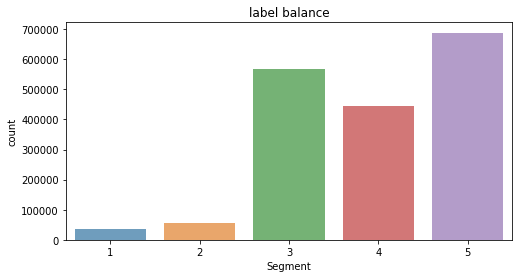

validation
5    172136
3    141651
4    111452
2     14093
1      9214
Name: Segment, dtype: int64


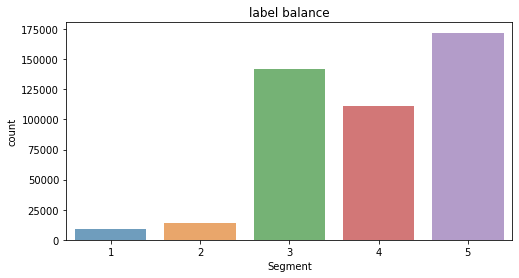

In [37]:
for d, name in zip([train, valid], ['train', 'validation']):
    print(name)
    eda_functions.show_label_balance(d, label='Segment')

In [38]:
del train
del valid

# Обучение моделей

In [39]:
skf = StratifiedKFold(n_splits=3 ,shuffle=True, random_state=42) 
def validate(params, X_train, y_train, skf):
    w = [] 
    best_iter = [] 
    for train_index, val_index in skf.split(X_train, y_train): 
        X_train_0, X_val_0 = X_train.loc[train_index, :], X_train.loc[val_index, :] 
        y_train_0, y_val_0 = y_train.loc[train_index], y_train.loc[val_index] 
        train_data = lgb.Dataset(X_train_0, label=y_train_0) 
        val_data = lgb.Dataset(X_val_0, label=y_val_0) 
         
        model = lgb.train(params 
                      , train_data 
                      , valid_sets=[train_data, val_data] 
                      , valid_names=['train', 'val'] 
                      , num_boost_round=1000 
                      , verbose_eval=10 
                      , early_stopping_rounds=3) 
         
        w.append([model.best_score['train']['auc'], model.best_score['val']['auc']]) 
         
        best_iter.append(model.best_iteration) 
         
    nrounds = np.mean(best_iter) 
    print(w) 
    res=list(np.mean(w, axis=0)) 
     
     
    print(f"""
    Result of cross-validatation with params {params} :
    ,Mean auc train {res[0]} 
    , mean auc test {res[1]} 
    , dif {abs(res[0]-res[1])} """) 
    return res

In [40]:
X_train.head(2)

,gamecategory,subgamecategory,bundle,oblast,city,os,osv,population,children,type,latitude_dd,longitude_dd,timezone,os_,new_phone,osv,loc_minute,loc_hour,loc_day,loc_month,loc_weekday,loc_is_weekend,loc_days_to_weekend,loc_is_academic_year,loc_is_first_september,loc_is_week_before_first_september,loc_is_early_morning,loc_is_morning,loc_is_day,loc_is_evening,loc_is_late_evening,loc_is_night,loc_weekday_tag,loc_is_weekend_tag,loc_is_academic_year_tag,loc_time_of_day_tag
0,NaN,NaN,COM.MUSCLE.RUSH,саха (якутия),якутск,ANDROID,1,NaN,NaN,NaN,NaN,NaN,7,ANDROID,old_phone,1,59.0,9.0,0.0,9.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,суббота,выходной,учебный_год,утро
1,NaN,NaN,COM.PERCENT.ROYALDICE,ставрополье,ставрополь,ANDROID,1,NaN,NaN,NaN,NaN,NaN,0,ANDROID,old_phone,1,27.0,2.0,0.0,8.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,вторник,рабочий_день,каникулы,ночь


In [41]:
target_names = [col for col in y_train.columns]
category_cols = list(set(X_train.columns) - set(['timezone','osv','population','children','latitude_dd','longitude_dd','loc_minute','loc_hour','loc_day','loc_month','loc_weekday','loc_is_weekend','loc_days_to_weekend','loc_is_academic_year','loc_is_first_september','loc_is_week_before_first_september','loc_is_early_morning','loc_is_morning','loc_is_day','loc_is_evening','loc_is_late_evening','loc_is_night']))
print(target_names)
print(category_cols)

['Segment_1', 'Segment_2', 'Segment_3', 'Segment_4', 'Segment_5']
['os', 'bundle', 'loc_is_weekend_tag', 'loc_weekday_tag', 'city', 'gamecategory', 'loc_is_academic_year_tag', 'subgamecategory', 'type', 'oblast', 'loc_time_of_day_tag', 'new_phone', 'os_']


In [42]:
for col in category_cols:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

for col in ['osv','timezone']:
    X_train[col] = X_train[col].astype('float')
    X_valid[col] = X_valid[col].astype('float') 

In [55]:
pars = {}
models = {}
pars['Segment_1'] = {
    'verbose': -1,
    'num_leaves': 31,
    'num_boost_round':  400,
    'learning_rate': 0.1,
    'metric': 'auc',
    'objective': 'binary',
    'class_weight': 'balanced',
}

pars['Segment_2'] = {
    'verbose': -1,
    'num_leaves': 31,
    'num_boost_round':  400,
    'learning_rate': 0.15,
    'metric': 'auc',
    'objective': 'binary',
    'class_weight': 'balanced',
}

pars['Segment_3'] = {
    'verbose': -1,
    'num_leaves': 31,
    'num_boost_round':  400,
    'learning_rate': 0.3,
    'metric': 'auc',
    'objective': 'binary',
    'class_weight': 'balanced',
}

pars['Segment_4'] = {
    'verbose': -1,
    'num_leaves': 31,
    'num_boost_round':  400,
    'learning_rate': 0.3,
    'metric': 'auc',
    'objective': 'binary',
    'class_weight': 'balanced',
}

pars['Segment_5'] = {
    'verbose': -1,
    'num_leaves': 31,
    'num_boost_round':  400,
    'learning_rate': 0.3,
    'metric': 'auc',
    'objective': 'binary',
    'class_weight': 'balanced',
}

In [56]:
val = {}
for targ in target_names:
    val[targ] = validate(pars[targ], X_train, y_train[targ], skf)


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.898199	val's auc: 0.887752
[20]	train's auc: 0.905363	val's auc: 0.891072
[30]	train's auc: 0.910099	val's auc: 0.892071
Early stopping, best iteration is:
[36]	train's auc: 0.912675	val's auc: 0.892698
Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.898064	val's auc: 0.886531
[20]	train's auc: 0.905107	val's auc: 0.889732
[30]	train's auc: 0.909939	val's auc: 0.890993
Early stopping, best iteration is:
[34]	train's auc: 0.911753	val's auc: 0.891475
Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.89864	val's auc: 0.88847
[20]	train's auc: 0.905886	val's auc: 0.890891
Early stopping, best iteration is:
[20]	train's auc: 0.905886	val's auc: 0.890891
[[0.9126751531316054, 0.8926979569013346], [0.911753457021683, 0.8914750870183699], [0.9058862137209489, 0.8908905595097167]]

    Result of cross-validatation with params {'verbose': -1, 'num_leav

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.949051	val's auc: 0.945635
[20]	train's auc: 0.953235	val's auc: 0.947633
[30]	train's auc: 0.955628	val's auc: 0.948086
Early stopping, best iteration is:
[33]	train's auc: 0.95615	val's auc: 0.948183
Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.948485	val's auc: 0.945644
[20]	train's auc: 0.952376	val's auc: 0.947119
[30]	train's auc: 0.954746	val's auc: 0.947781
Early stopping, best iteration is:
[30]	train's auc: 0.954746	val's auc: 0.947781
Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.949049	val's auc: 0.945785
[20]	train's auc: 0.95297	val's auc: 0.947176
Early stopping, best iteration is:
[26]	train's auc: 0.954065	val's auc: 0.947309
[[0.9561498010815522, 0.9481830028770315], [0.9547456374023022, 0.9477809477382922], [0.9540646199577086, 0.9473092740154939]]

    Result of cross-validatation with params {'verbose': -1, 'num_lea

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.8197	val's auc: 0.818782
[20]	train's auc: 0.829538	val's auc: 0.825646
[30]	train's auc: 0.834212	val's auc: 0.827396
[40]	train's auc: 0.837489	val's auc: 0.828635
Early stopping, best iteration is:
[40]	train's auc: 0.837489	val's auc: 0.828635
Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.820791	val's auc: 0.817782
[20]	train's auc: 0.829173	val's auc: 0.823563
[30]	train's auc: 0.832953	val's auc: 0.82478
[40]	train's auc: 0.83747	val's auc: 0.826965
Early stopping, best iteration is:
[45]	train's auc: 0.83958	val's auc: 0.827591
Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.819692	val's auc: 0.816688
[20]	train's auc: 0.829809	val's auc: 0.824105
[30]	train's auc: 0.834203	val's auc: 0.82585
Early stopping, best iteration is:
[30]	train's auc: 0.834203	val's auc: 0.82585
[[0.8374892842637867, 0.8286348942016282], [0.839579546038022

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.828017	val's auc: 0.824474
[20]	train's auc: 0.837413	val's auc: 0.83066
[30]	train's auc: 0.841988	val's auc: 0.833077
[40]	train's auc: 0.847035	val's auc: 0.835415
Early stopping, best iteration is:
[39]	train's auc: 0.846881	val's auc: 0.835448
Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.829017	val's auc: 0.823866
[20]	train's auc: 0.837794	val's auc: 0.829831
[30]	train's auc: 0.842818	val's auc: 0.831938
Early stopping, best iteration is:
[31]	train's auc: 0.84345	val's auc: 0.83246
Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.829581	val's auc: 0.826372
[20]	train's auc: 0.840554	val's auc: 0.833608
[30]	train's auc: 0.845915	val's auc: 0.835945
[40]	train's auc: 0.849619	val's auc: 0.837366
Early stopping, best iteration is:
[40]	train's auc: 0.849619	val's auc: 0.837366
[[0.8468807812839027, 0.835447916669939], [0.843449756806

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.893872	val's auc: 0.893693
[20]	train's auc: 0.899955	val's auc: 0.897789
[30]	train's auc: 0.903203	val's auc: 0.899457
Early stopping, best iteration is:
[33]	train's auc: 0.903605	val's auc: 0.899483
Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.892252	val's auc: 0.890843
[20]	train's auc: 0.898289	val's auc: 0.895347
[30]	train's auc: 0.903625	val's auc: 0.899245
[40]	train's auc: 0.906196	val's auc: 0.899931
Early stopping, best iteration is:
[37]	train's auc: 0.905817	val's auc: 0.900038
Training until validation scores don't improve for 3 rounds.
[10]	train's auc: 0.894051	val's auc: 0.891469
[20]	train's auc: 0.89938	val's auc: 0.894721
[30]	train's auc: 0.903778	val's auc: 0.897651
[40]	train's auc: 0.906879	val's auc: 0.89892
Early stopping, best iteration is:
[44]	train's auc: 0.908707	val's auc: 0.899875
[[0.9036045162109304, 0.8994825001367963], [0.9058170907

In [45]:
val

{'Segment_1': [0.9101049412914124, 0.8916878678098069],
 'Segment_2': [0.9549866861471877, 0.9477577415436059],
 'Segment_3': [0.8370904658840536, 0.8273588279249567],
 'Segment_4': [0.8466498385295478, 0.8350911423462869],
 'Segment_5': [0.9060430342930008, 0.8997986862444982]}

In [57]:
pars['Segment_1'].update({'num_boost_round':30})
pars['Segment_2'].update({'num_boost_round':30})
pars['Segment_3'].update({'num_boost_round':38})
pars['Segment_4'].update({'num_boost_round':37})
pars['Segment_5'].update({'num_boost_round':38})

In [60]:
for targ in target_names:
    train_data = lgb.Dataset(X_train, label=y_train[targ]) 
    val_data = lgb.Dataset(X_valid, label=y_valid[targ]) 
    models[targ] = lgb.train(pars[targ] 
                            , train_data 
                            , valid_sets=[train_data, val_data] 
                            , valid_names=['train', 'val'] 
                            , verbose_eval=10) 

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[10]	train's auc: 0.895787	val's auc: 0.881332
[20]	train's auc: 0.902789	val's auc: 0.88584
[30]	train's auc: 0.90677	val's auc: 0.88736
[10]	train's auc: 0.948718	val's auc: 0.939262
[20]	train's auc: 0.952083	val's auc: 0.940723
[30]	train's auc: 0.953826	val's auc: 0.941053
[10]	train's auc: 0.819696	val's auc: 0.811039
[20]	train's auc: 0.828555	val's auc: 0.818317
[30]	train's auc: 0.83316	val's auc: 0.821283
[10]	train's auc: 0.828126	val's auc: 0.818982
[20]	train's auc: 0.837454	val's auc: 0.82665
[30]	train's auc: 0.842334	val's auc: 0.829557
[10]	train's auc: 0.892912	val's auc: 0.882235
[20]	train's auc: 0.898083	val's auc: 0.886854
[30]	train's auc: 0.902167	val's auc: 0.889883


In [61]:
for targ in target_names:
    validate_model(models[targ], X_train, y_train[targ], X_valid, y_valid[targ])

model
Train roc auc 0.9067695841484021
Validation roc auc 0.8873600499274872
model
Train roc auc 0.9538260714248683
Validation roc auc 0.9410533633281727
model
Train roc auc 0.8368352845002106
Validation roc auc 0.8237295894391203
model
Train roc auc 0.8439262470475721
Validation roc auc 0.8302665086274066
model
Train roc auc 0.9043968775872986
Validation roc auc 0.891078818695486


# Сохраняем модели

In [62]:
version = 'v2.0'
for targ in target_names:
    model_name = f'lgbm_segment_{targ}_{version}.pkl'
    joblib.dump(models[targ], os.path.join(LGBM_MODELS_FOLDER, model_name))

# Верифицируем, что всё сохранилось хорошо и модели работают

In [63]:
loaded_models = {}
version = 'v2.0'
for targ in target_names:
    model_name = f'lgbm_segment_{targ}_{version}.pkl'
    loaded_models[targ] = joblib.load(os.path.join(LGBM_MODELS_FOLDER, model_name))

In [64]:
for targ in target_names:
    validate_model(loaded_models[targ], X_train, y_train[targ], X_valid, y_valid[targ])

model
Train roc auc 0.9067695841484021
Validation roc auc 0.8873600499274872
model
Train roc auc 0.9538260714248683
Validation roc auc 0.9410533633281727
model
Train roc auc 0.8368352845002106
Validation roc auc 0.8237295894391203
model
Train roc auc 0.8439262470475721
Validation roc auc 0.8302665086274066
model
Train roc auc 0.9043968775872986
Validation roc auc 0.891078818695486


# Визуализация

In [65]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [68]:
shap_values = shap.TreeExplainer(models['Segment_1']).shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


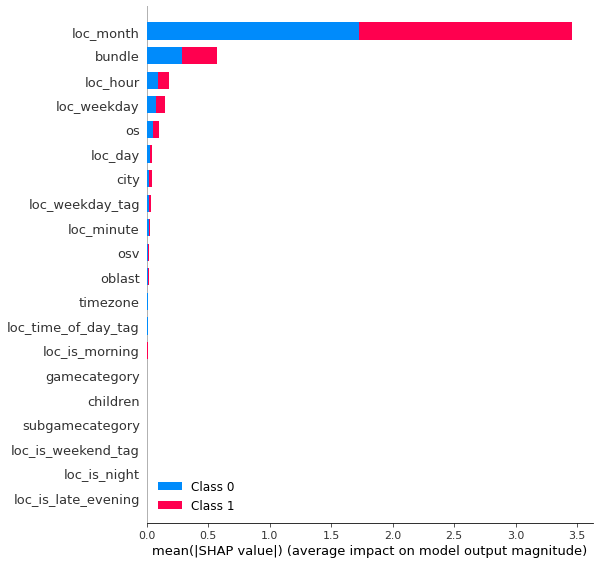

In [69]:
shap.summary_plot(shap_values, X_train)

In [70]:
explainer = shap.TreeExplainer(models['Segment_2']) 
shap_value_test = explainer.shap_values(X_train) 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


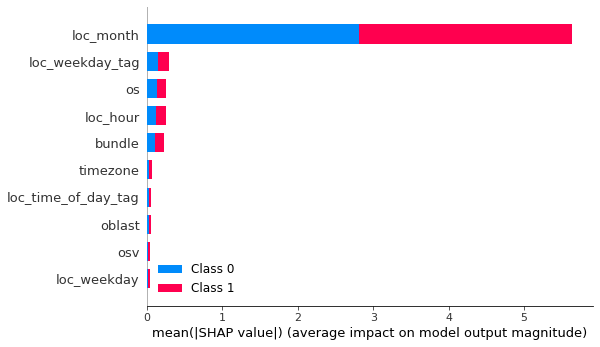

In [72]:
shap.summary_plot(shap_value_test, X_train, max_display=10)

In [66]:
explainer = shap.TreeExplainer(models['Segment_3']) 
shap_value_test = explainer.shap_values(X_train) 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


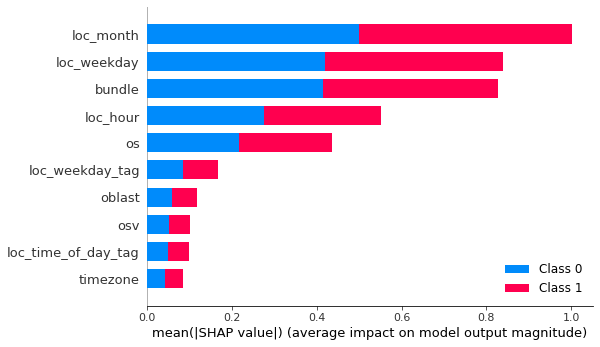

In [67]:
shap.summary_plot(shap_value_test, X_train, max_display=10)

# Предикт теста

## Подготовка данных

In [8]:
def predict_on_test():
    print('reading test...')
    test_raw = pd.read_csv(os.path.join(DATA_FOLDER, TEST_FILE))
    print(test_raw.shape)
    print('preprocessing test...')
    test_raw_preprocessed = preprocess_text_features(test_raw)
    with open(os.path.join(MODES_FOLDER, 'mode_subgamecategory.pkl'), mode='rb') as file:
        mode_sub = pickle.load(file)
    with open(os.path.join(MODES_FOLDER, 'mode_gamecategory.pkl'), mode='rb') as file:
        mode_game = pickle.load(file)
    test_raw_preprocessed['subgamecategory'] = feature_preprocess.impute_column_test(test_raw_preprocessed, 'subgamecategory', mode_sub)
    test_raw_preprocessed['gamecategory'] = feature_preprocess.impute_column_test(test_raw_preprocessed, 'gamecategory', mode_game)
    test_raw_preprocessed = feature_preprocess.make_features_from_cities(test_raw_preprocessed, PATH_CITIES)

    test_raw_time_ftrs = \
      feature_preprocess.make_features_from_time(
        test_raw_preprocessed,
        dt_target='loc',
        datetime_col_msk='created',
        shift_col = 'shift',
        fill_shift_na=False,
        shift_filler='MSK',
        dt_format = '%Y-%m-%d %H:%M:%S'
        )
    print('make_features_from_time done')

    test_raw_time_tags = feature_preprocess.get_tags_from_time_features(
        test_raw_time_ftrs, 
        tags_cols=TIME_TAGS_COLS, 
        tags_dict=None)

    print('get_tags_from_time_features done')

    test_raw_all_ftrs = pd.concat([test_raw_preprocessed, test_raw_time_ftrs.reset_index(drop=True), test_raw_time_tags.reset_index(drop=True)], axis=1)
    test_raw_all_ftrs.drop(columns=['created', 'shift'], inplace=True)

    print('dataset prepared successfully')

    test_raw_all_ftrs['osv'] = test_raw_all_ftrs['osv'].replace('',0)
    target_names = ['Segment_1', 'Segment_2', 'Segment_3', 'Segment_4', 'Segment_5']
    category_cols = ['os', 'bundle', 'loc_is_weekend_tag', 'loc_weekday_tag', 'city', 'gamecategory', 'loc_is_academic_year_tag', 'subgamecategory', 'type', 'oblast', 'loc_time_of_day_tag', 'new_phone', 'os_']
    for col in category_cols:
      test_raw_all_ftrs[col] = test_raw_all_ftrs[col].astype('category')

    for col in ['osv','timezone']:
        test_raw_all_ftrs[col] = test_raw_all_ftrs[col].astype('float')

    test_predic = {}
    for targ in target_names:
        test_predic[targ] = loaded_models[targ].predict(test_raw_all_ftrs)

    test_predictions = pd.DataFrame(dtype=np.float64)
    for targ in target_names:
        test_predictions[f'{targ}_proba'] = test_predic[targ]

    postfix = '_lgbm_Marina_v2'
    test_predictions.to_csv(os.path.join(OUTPUT_FOLDER, f'test_predictions{postfix}.csv'), index=False)
    display(test_predictions)

In [9]:
predict_on_test()

reading test...
(11213629, 9)
preprocessing test...


FileNotFoundError: ignored